# Neural Network

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler


device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [19]:
# Define the neural network architecture

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11, 64), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64,32), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits 
  
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

def init_weights(m):
    if isinstance(m, nn.Linear):
        if m.out_features == 1:
            # Output layer → Xavier, bias = mean target
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, target_mean)
        else:
            # Hidden layers → Kaiming for ReLU
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            nn.init.zeros_(m.bias)

In [6]:
#Load dataset
df = pd.read_csv('../WineQuality.csv')

# Drop redundant columns
df.drop(columns=['total sulfur dioxide'], inplace=True)

# Convert type to numeric
type_to_numeric = {'white': 0, 'red': 1}
df['type'] = df['type'].map(type_to_numeric)

#Split dataset into features and target
target = df['quality']
feature = df.drop(columns=['quality'])

# Split the dataset into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(feature, target, test_size=0.2, random_state=27)

# Imputation of missing values
imputer = SimpleImputer(strategy='mean')
xtrain = imputer.fit_transform(xtrain)
xtest = imputer.transform(xtest)

# Normalization of data
norm = MinMaxScaler()
xtrain = norm.fit_transform(xtrain)
xtest = norm.transform(xtest)

# Convert ytrain to a tensor
ytrain = torch.tensor(ytrain.values, dtype=torch.float32).view(-1, 1)
ytest = torch.tensor(ytest.values, dtype=torch.float32).view(-1, 1)

# Prepare train_loader
train_dataset = TensorDataset(torch.tensor(xtrain, dtype=torch.float32), ytrain)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Compute train mean from data
target_mean = ytrain.mean().item()  # average quality in training set
print("Target mean:", target_mean)


Target mean: 5.823359489440918


In [29]:
model = NeuralNetwork().to(device)
model.apply(init_weights)

lr = 0.001
gamma = 0.9
loss_fn = nn.HuberLoss(delta=1.0)
optimizer = optim.RMSprop(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)


num_epochs = 400
best = float("inf"); patience, bad = 25, 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_mae = 0.0

    for xbatch, ybatch in train_loader:
        xbatch = xbatch.to(device)                         # (N, 11) float32
        ybatch = ybatch.to(device).float().view(-1, 1)     # (N, 1) float32

        preds = model(xbatch)                              # (N, 1)

        loss = loss_fn(preds, ybatch)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_mae += torch.mean(torch.abs(preds - ybatch)).item()

    train_loss /= len(train_loader)
    train_rmse = (train_loss) ** 0.5
    train_mae /= len(train_loader)

    scheduler.step()


    model.eval()
    xtest_tensor = torch.tensor(xtest, dtype=torch.float32).to(device)
    ytest_tensor = ytest.to(device).float().view(-1, 1)
    test_loss_total, test_mae_total, n_batches = 0.0, 0.0, 0

    with torch.inference_mode():
        test_preds = model(xtest_tensor)
        test_loss = loss_fn(test_preds, ytest_tensor).item()
        test_rmse = (test_loss) ** 0.5
        test_mae = torch.mean(torch.abs(test_preds - ytest_tensor)).item()

    current_lr = optimizer.param_groups[0]['lr']

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Huber: {train_loss:.4f} | Train RMSE: {train_rmse:.4f} | Train MAE: {train_mae:.4f} || "
        f"Test Huber: {test_loss:.4f} | Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f} || "
        f"LR: {current_lr:.6f}"
    )

    # Gradient presence check
    for name, p in model.named_parameters():
        if p.grad is None:
            print(f"No gradient for {name}")

    if test_rmse < best - 1e-6:
        best, bad = test_rmse, 0
        best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
    else:
        bad += 1
        if bad >= patience: break
    model.load_state_dict(best_state)

print(f"Complete with Epoch {epoch+1-bad}")


Epoch [1/400] Train Huber: 0.2784 | Train RMSE: 0.5276 | Train MAE: 0.6232 || Test Huber: 0.2629 | Test RMSE: 0.5128 | Test MAE: 0.6039 || LR: 0.000900
Epoch [2/400] Train Huber: 0.2549 | Train RMSE: 0.5049 | Train MAE: 0.5880 || Test Huber: 0.2546 | Test RMSE: 0.5046 | Test MAE: 0.5917 || LR: 0.000810
Epoch [3/400] Train Huber: 0.2494 | Train RMSE: 0.4994 | Train MAE: 0.5825 || Test Huber: 0.2479 | Test RMSE: 0.4979 | Test MAE: 0.5783 || LR: 0.000729
Epoch [4/400] Train Huber: 0.2479 | Train RMSE: 0.4979 | Train MAE: 0.5796 || Test Huber: 0.2475 | Test RMSE: 0.4975 | Test MAE: 0.5799 || LR: 0.000656
Epoch [5/400] Train Huber: 0.2436 | Train RMSE: 0.4936 | Train MAE: 0.5737 || Test Huber: 0.2464 | Test RMSE: 0.4964 | Test MAE: 0.5750 || LR: 0.000590
Epoch [6/400] Train Huber: 0.2423 | Train RMSE: 0.4922 | Train MAE: 0.5708 || Test Huber: 0.2460 | Test RMSE: 0.4960 | Test MAE: 0.5761 || LR: 0.000531
Epoch [7/400] Train Huber: 0.2427 | Train RMSE: 0.4927 | Train MAE: 0.5708 || Test Huber

## Data Processing

### Residual Plots

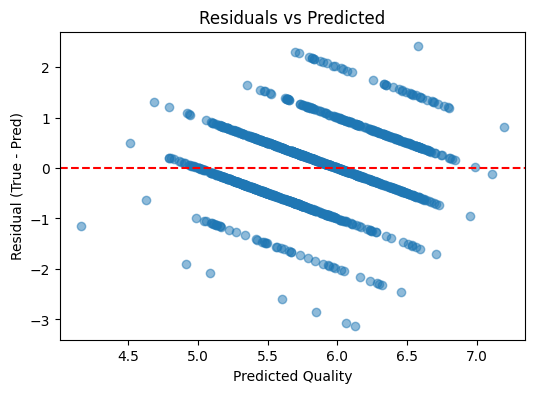

In [39]:
model.eval()
with torch.inference_mode():
    preds = model(torch.tensor(xtest, dtype=torch.float32).to(device)).cpu().numpy().flatten()

true_vals = ytest.cpu().numpy().flatten()

df_eval = pd.DataFrame({
    "true": true_vals,
    "pred": preds
})
residuals = true_vals - preds

plt.figure(figsize=(6,4))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Quality")
plt.ylabel("Residual (True - Pred)")
plt.title("Residuals vs Predicted")
plt.show()

### Splitting Based on Quality

true
3.0    2.399473
4.0    1.559148
5.0    0.538343
6.0    0.340069
7.0    0.769311
8.0    1.679787
9.0    2.422711
Name: error, dtype: float32


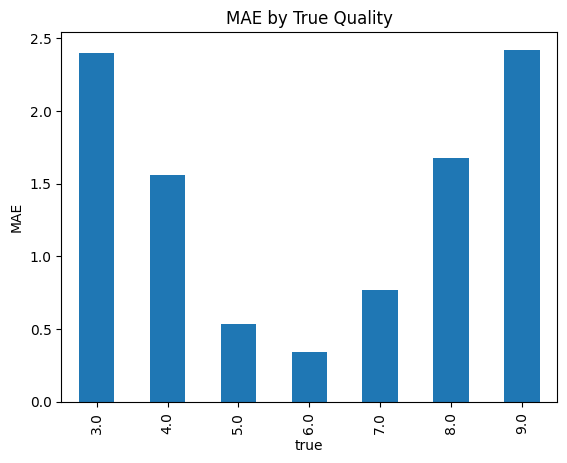

In [40]:
df_eval["error"] = np.abs(df_eval["true"] - df_eval["pred"])

bucketed = df_eval.groupby("true")["error"].mean()
print(bucketed)

bucketed.plot(kind="bar", ylabel="MAE", title="MAE by True Quality")
plt.show()

### Splitting based on Type of wine

type
0.0    0.585178
1.0    0.534240
Name: error, dtype: float32


<Axes: title={'center': 'MAE by Wine Type (0=white, 1=red)'}, xlabel='type', ylabel='MAE'>

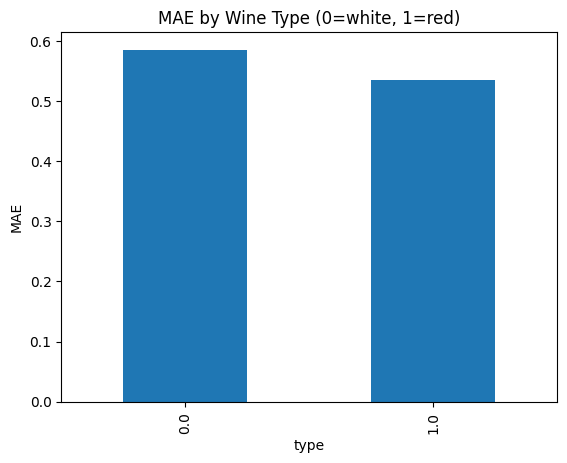

In [ ]:
wine_types = xtest[:, 0]  # first column is 'type'
df_eval["type"] = wine_types

type_mae = df_eval.groupby("type")["error"].mean()
print(type_mae)

type_mae.plot(kind="bar", ylabel="MAE", title="MAE by Wine Type (0=white, 1=red)")